In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
from matplotlib.markers import MarkerStyle
import matplotlib.pyplot as plt
from shapely import wkt
import pickle
import json
import numpy as np

/Users/berendmarkhorst/Library/Mobile Documents/com~apple~CloudDocs/PhD/READINESS/08 - Trondheim/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Convert Table 4 to Figure
I want to visualize at which facilities the different traders are active.

In [4]:
file = "Data/OurData2.xlsx"
nodes_df = pd.read_excel(file, sheet_name="Nodes", skiprows=1)
shipper_df = pd.read_excel(file, sheet_name="Traders")

# We include this to merge with the shipper df later
nodes_df["Name lowercase"] = nodes_df["Name"].str.lower()
nodes_df.set_index("Name lowercase", inplace = True)

In [5]:
trader_abbreviated_names = ["Shell", "Aker BP", "ConocoPhillips", "Equinor", "Lundin Energy", "Neptune Energy", "Var Energi", "Wintershall DEA"]

def get_short_name(trader):
    return [t for t in trader_abbreviated_names if t in trader][0]

In [6]:
nodes_geo_df = gpd.GeoDataFrame(nodes_df, geometry=nodes_df[["X_coordinate", "Y_coordinate"]].apply(Point, axis=1)).set_crs(4326).to_crs(32631)

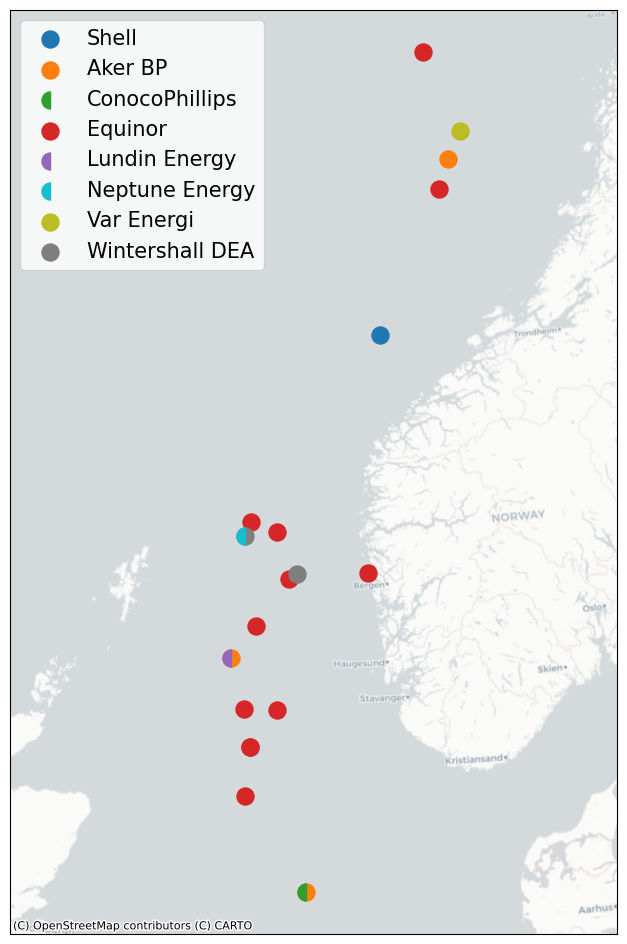

In [5]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
          "#9467bd", "#17becf", "#bcbd22", "#7f7f7f"]

traders = shipper_df.columns
trader_dict = {}
for i, trader in enumerate(traders):
    facilities_of_trader = shipper_df[trader].str.lower()[:12].dropna().values
    if trader in ["ConocoPhillips Skandinavia AS", "Lundin Energy Norway AS", "Neptune Energy Norge AS"]:
        marker = MarkerStyle("o", fillstyle="left")
        z = 100
    else:
        z = 1
        marker = MarkerStyle("o")

    short_name_trader = get_short_name(trader)
    nodes_geo_df.loc[facilities_of_trader].plot(figsize=(20,30), color=colors[i], ax=plt.gca(), marker=marker, label=short_name_trader, zorder = z, markersize=150)

plt.xlim(100000,950000)
plt.gcf().set_size_inches(12,12)
plt.legend(fontsize=15)
plt.xticks([])
plt.yticks([])
cx.add_basemap(ax=plt.gca(), crs=32631, source=cx.providers.CartoDB.Positron)

plt.savefig("Figures/traders.pdf", bbox_inches='tight')

plt.show()

# Visualize minimum contracts

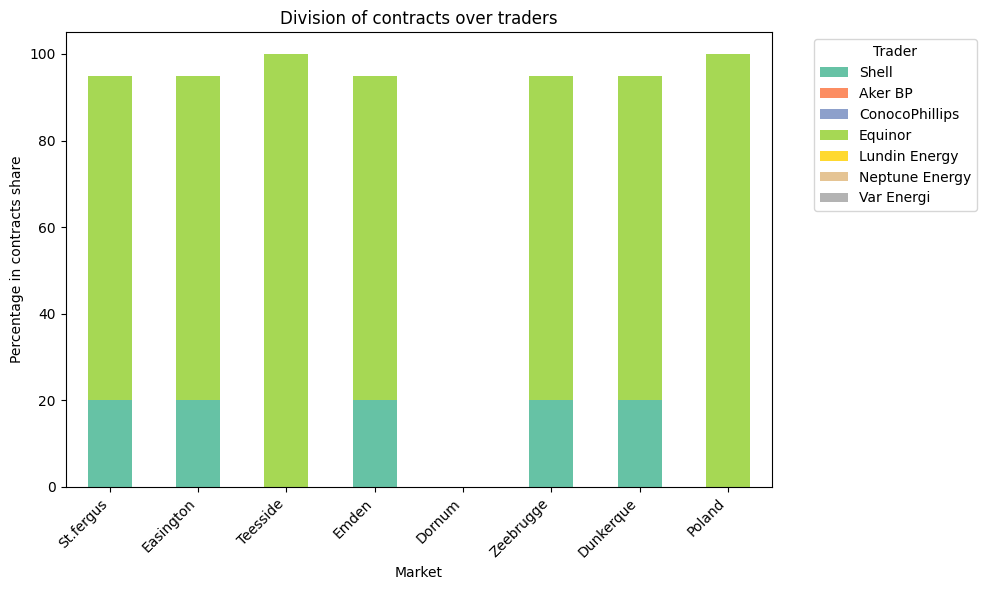

In [6]:
trader_percentages_df = pd.read_excel(file, sheet_name="TraderPercentages")

# Only select the relevent part of the dataframe
trader_percentages_df = trader_percentages_df.iloc[:7][trader_percentages_df.columns[:9]]
trader_percentages_df["Trader"] = trader_percentages_df["Trader"].apply(lambda x: get_short_name(x))
trader_percentages_df.set_index("Trader", inplace=True)
trader_percentages_df.columns = trader_percentages_df.columns.str.capitalize()
trader_percentages_df = trader_percentages_df * 100
trader_percentages_df = trader_percentages_df.T

# Plot stacked bar chart
trader_percentages_df.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="Set2")

# Labels and title
plt.xlabel("Market")
plt.ylabel("Percentage in contracts share")
plt.title("Division of contracts over traders")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Trader", bbox_to_anchor=(1.05, 1), loc="upper left")

# Show plot
plt.tight_layout()
plt.savefig("Figures/minimum_contracts.pdf", bbox_inches='tight')
plt.show()

# Visualize facilities and pipes

In [7]:
arcs_df = pd.read_excel(file, sheet_name="Arcs")
arcs_df["geometry"] = arcs_df["geometry"].apply(wkt.loads)
arcs_geo_df = gpd.GeoDataFrame(arcs_df, geometry="geometry").set_crs(4326).to_crs(32631)

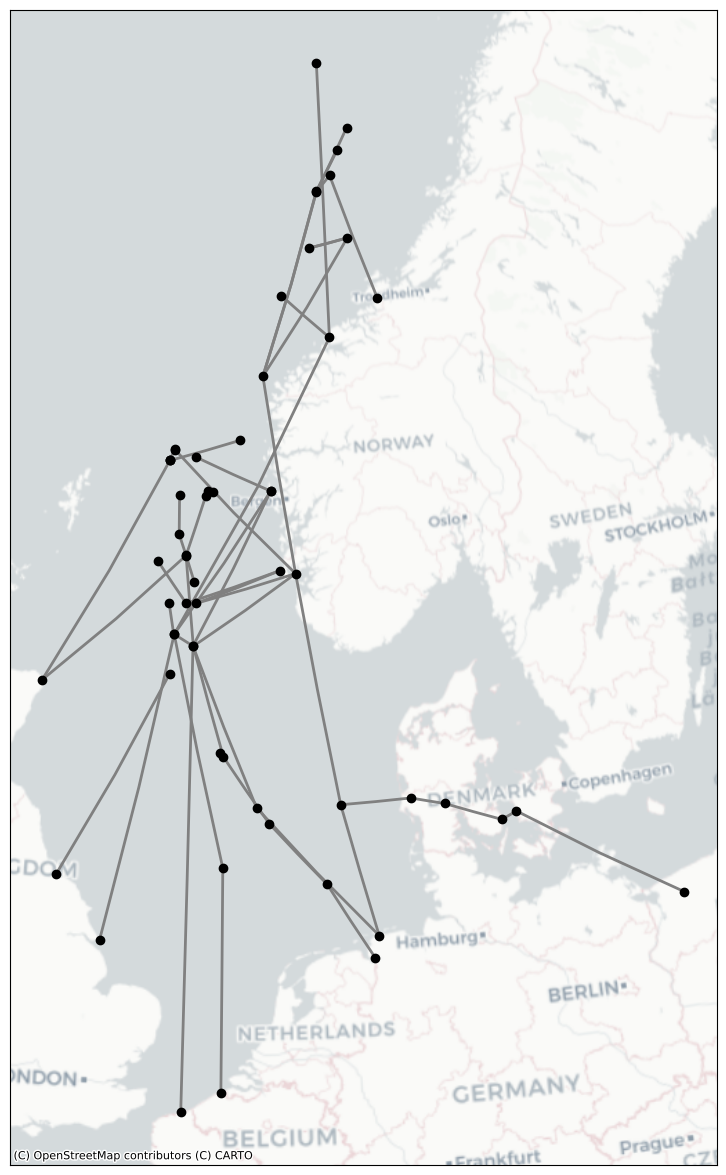

In [8]:
nodes_geo_df.plot(figsize=(10,15),zorder=2, color="black")
arcs_geo_df.plot(ax=plt.gca(), color='gray', linewidth=2, zorder=1)
cx.add_basemap(ax=plt.gca(), crs=32631, source=cx.providers.CartoDB.Positron)

plt.xticks([])
plt.yticks([])
plt.savefig("Figures/network.pdf", bbox_inches='tight')
plt.show()

# 4.3.1 Capacity booking in primary and secondary markets

In [13]:
def read_data(input_file):
    # Load the problem instance back from the file
    with open(f"{input_file}.pkl", "rb") as file:
        problem = pickle.load(file)

    # Read a dictionary from a json file
    solution = {}
    var_names = ["x_plus", "x_minus", "y_plus", "y_minus", "s_plus", "s_minus", "f", "q_sales", "q_production", "v", "w_plus", "w_minus"]
    
    for var_name in var_names:
        df = pd.read_csv(f"{input_file}_{var_name}.csv", sep=";")

        indices = [f"Index {i}" for i in range(1, len(df.columns))]
        df.columns = indices + ["Value"]
        
        solution[var_name] = df

    return problem, solution

def get_value_from_solution(key, solution):
    return solution[key] if key in solution.keys() else 0

In [127]:
input_file = "Results/result_v2_A"

problem, solution = read_data(input_file)

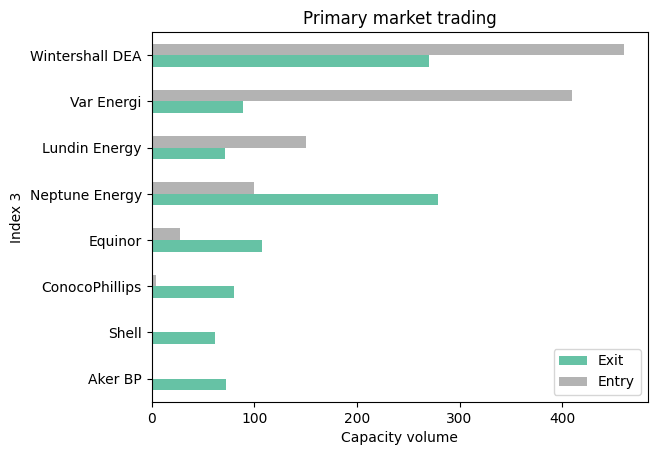

In [129]:
def primary_market(key, name):
    df = solution[key].copy()
    long_term_df = df[df["Index 2"] <= 4]

    grouped_df = long_term_df.groupby("Index 3").sum()[["Value"]]
    grouped_df.columns = [name]

    traders_dict = {t.trader_id: get_short_name(t.name) for t in problem.traders}

    grouped_df.index = grouped_df.index.map(traders_dict)
    
    return grouped_df

entry = primary_market("x_plus", "Entry")
exit = primary_market("x_minus", "Exit")

df = pd.concat([exit, entry], axis=1)

df.sort_values("Entry").plot(kind="barh", cmap="Set2")

plt.xlabel("Capacity volume")

plt.title("Primary market trading");


Show for second and third stage per scenario who sells and buys how much exit capacity.

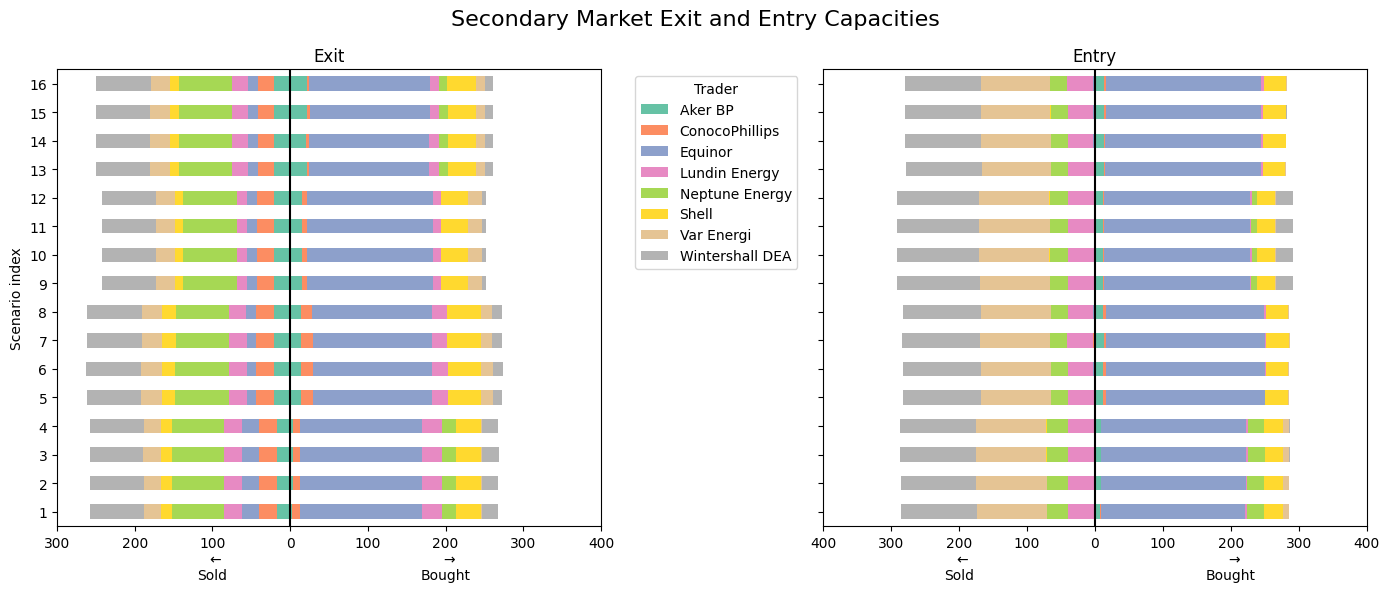

In [196]:
def secondary_market(key, name):
    df = solution[key].copy()

    traders_dict = {t.trader_id: get_short_name(t.name) for t in problem.traders}
    df["Index 3"] = df["Index 3"].map(traders_dict)

    # Add stages
    df["Stage"] = df["Index 2"].apply(lambda x: 1 if x <= 4 else 2 if x <= 20 else 3)
    df = df[df["Stage"] > 1]
    
    # Add scenarios
    df["Scenario index"] = np.where(
        df["Stage"] == 2,
        (df["Index 2"] - 5) // 4 + 1,
        (df["Index 2"] - 21) // 4 + 1
    )
    
    probabilities = {m.stage_id: m.probability for m in problem.stages}
    df["Probability"] = df["Index 2"].map(probabilities)
    
    df["Weighted value"] = df["Probability"] * df["Value"]
    
    df_stage2 = df[df["Stage"] == 2]
    df_stage2 = df_stage2.groupby(["Scenario index", "Index 3"]).sum()[["Weighted value"]]
    
    df_stage3 = df[df["Stage"] == 3]
    df_stage3 = df_stage3.groupby(["Scenario index", "Index 3"]).sum()[["Weighted value"]]

    # Add a new column to identify which group of 4 each row belongs to
    df_stage3["Group"] = [((idx[0] - 1) // 4 + 1, idx[1]) for idx in df_stage3.index]
    
    # Add the corresponding value from df1
    df_stage3[name] = df_stage3["Weighted value"] + df_stage3["Group"].map(df_stage2["Weighted value"])
    
    return df_stage3[name].to_frame()


def plot_secondary_market(capacity_type, ax, show_legend=True):
    if capacity_type == "exit":
        key = "minus"
    else:
        key = "plus"
        
    entry_bought = secondary_market(f"x_{key}", "Bought")
    entry_sold = secondary_market(f"y_{key}", "Sold") * -1
    
    entry_sold_pivot = entry_sold.reset_index().set_index("Scenario index").pivot(columns=["Index 3"], values="Sold")
    entry_sold_pivot.sort_index(axis=1).plot(kind="barh", stacked=True, cmap="Set2", ax=ax)
    
    entry_bought_pivot = entry_bought.reset_index().set_index("Scenario index").pivot(columns=["Index 3"], values="Bought")
    entry_bought_pivot.sort_index(axis=1).plot(kind="barh", stacked=True, cmap="Set2", ax=ax)
    
    # Get legend handles and labels
    handles, labels = ax.get_legend_handles_labels()
    
    # Remove duplicates
    unique_labels = []
    unique_handles = []
    for h, l in zip(handles, labels):
        if l not in unique_labels:
            unique_labels.append(l)
            unique_handles.append(h)
    
    if show_legend:
        ax.legend(unique_handles, unique_labels, title="Trader", bbox_to_anchor=(1.05, 1), loc="upper left")
    else:
        ax.legend().set_visible(False)  # Hides the legend   

    ax.set_title(f"{capacity_type.capitalize()}")

    ax.axvline(x=0, color="black")

    # Get xtick positions and labels
    xticks = ax.get_xticks()
    xtick_labels = [f"{abs(tick):.0f}" for tick in xticks]
    
    # Add "Sold" and "Bought" once below the axis
    if any(tick < 0 for tick in xticks):
        negative_indices = [idx for idx, tick in enumerate(xticks) if tick <= 0]
        middle_idx = negative_indices[len(negative_indices) // 2]
        xtick_labels[middle_idx] += "\n " + r"$\leftarrow$" + "\n" + "Sold"
    if any(tick > 0 for tick in xticks):
        positive_indices = [idx for idx, tick in enumerate(xticks) if tick >= 0]
        middle_idx = positive_indices[len(positive_indices) // 2]
        xtick_labels[middle_idx] += "\n " + r"$\rightarrow$" + "\n" + "Bought"
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set_ylabel("Scenario index")

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)  # Two subplots side by side

# Plot both scenarios (exit and entry) on different subplots
plot_secondary_market("exit", axes[0], show_legend=True)  # First plot (exit)
plot_secondary_market("entry", axes[1], show_legend=False)  # Second plot (entry), no legend

# Add a global title for the whole figure
fig.suptitle("Secondary Market Exit and Entry Capacities", fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


Let's zoom in on the results for one specific scenario!

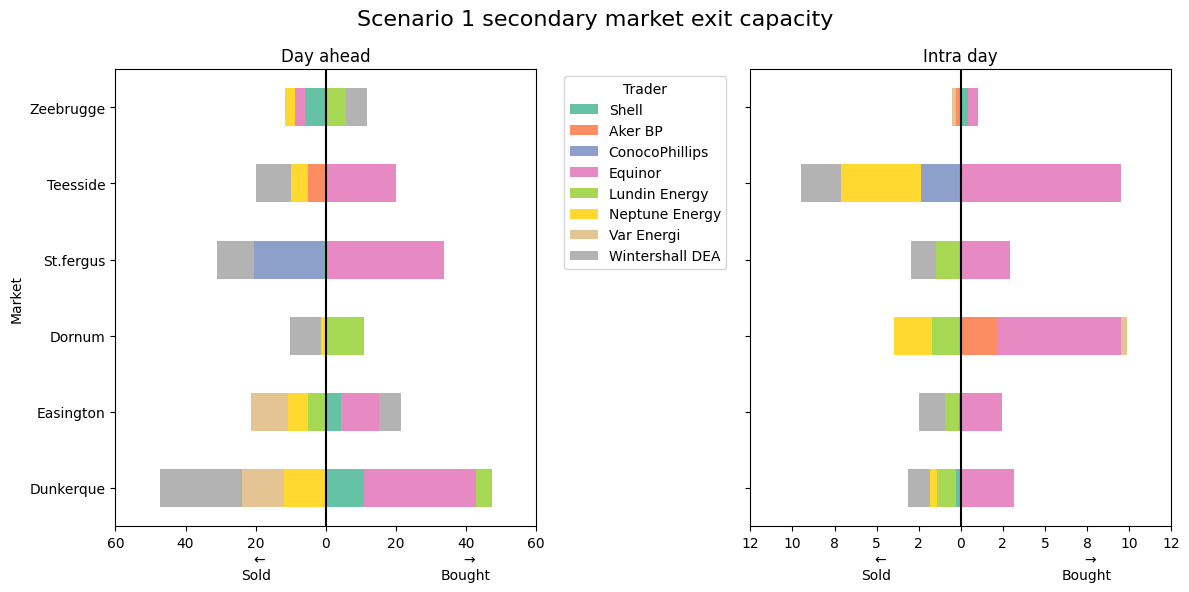

In [54]:
def plot_individual_scenario(ax, result_sold, result_bought, scenario_id, specific_name, show_legend):
    df1 = pd.DataFrame(result_sold[scenario_id])
    df2 = pd.DataFrame(result_bought[scenario_id])

    idx = (~(df1.eq(0).all(axis=1))) & ~(df2.eq(0).all(axis=1))
    df1 = df1.loc[idx]
    df2 = df2.loc[idx]

    df3 = df2 + df1

    df3.plot(kind="barh", stacked=True, ax=ax, cmap="Set2")
    
    ax.axvline(x=0, color="black")
    
    # Get legend handles and labels (only for the first subplot)
    handles, labels = ax.get_legend_handles_labels()
    
    if show_legend:
        # Remove duplicates
        unique_labels = []
        unique_handles = []
        for h, l in zip(handles, labels):
            if l not in unique_labels:
                unique_labels.append(l)
                unique_handles.append(h)
        
        # Add legend only once
        ax.legend(unique_handles, unique_labels, title="Trader", bbox_to_anchor=(1.05, 1), loc="upper left")
    else:
        ax.legend().set_visible(False)  # Hide legend for second plot

    # Get xtick positions and labels
    xticks = ax.get_xticks()
    xtick_labels = [f"{abs(tick):.0f}" for tick in xticks]
    
    # Add "Sold" and "Bought" labels
    if any(tick < 0 for tick in xticks):
        negative_indices = [idx for idx, tick in enumerate(xticks) if tick <= 0]
        middle_idx = negative_indices[len(negative_indices) // 2]
        xtick_labels[middle_idx] += "\n " + r"$\leftarrow$" + "\n" + "Sold"
    if any(tick > 0 for tick in xticks):
        positive_indices = [idx for idx, tick in enumerate(xticks) if tick >= 0]
        middle_idx = positive_indices[len(positive_indices) // 2]
        xtick_labels[middle_idx] += "\n " + r"$\rightarrow$" + "\n" + "Bought"
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set_ylabel("Market")
    
    ax.set_title(f"{specific_name.capitalize()}")

scenario_index = 1

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # Two subplots side by side
fig.suptitle(f"Scenario {scenario_index} secondary market exit capacity", fontsize=16)

for i, specific_name in enumerate(["day ahead", "intra day"]):
    result_bought, result_sold = {}, {}
    s = 0
    for m in problem.third_stages:
        if m.hour == 4:
            s += 1
            result_bought[s] = {}
            result_sold[s] = {}
            for t in problem.traders:
                short_name = get_short_name(t.name)
                result_bought[s][short_name] = {n.name.capitalize(): 0 for n in m.nodes}
                result_sold[s][short_name] = {n.name.capitalize(): 0 for n in m.nodes}
                for m_tilde in m.all_parents + [m]:
                    if m_tilde.name == specific_name:
                        for n in m_tilde.nodes:
                            result_bought[s][short_name][n.name.capitalize()] += sum(m_tilde.probability * get_value_from_solution(f"x_minus[{n.node_id},{m_tilde.stage_id},{t.trader_id},{k.commodity_id}]", solution) for k in problem.commodities)
                            result_sold[s][short_name][n.name.capitalize()] -= sum(m_tilde.probability * get_value_from_solution(f"y_minus[{n.node_id},{m_tilde.stage_id},{t.trader_id},{k.commodity_id}]", solution) for k in problem.commodities)
    
    # Pass the corresponding subplot (axes[i]) and only show the legend for the first plot
    plot_individual_scenario(axes[i], result_sold, result_bought, scenario_index, specific_name, show_legend=(i == 0))

plt.tight_layout()
plt.show()

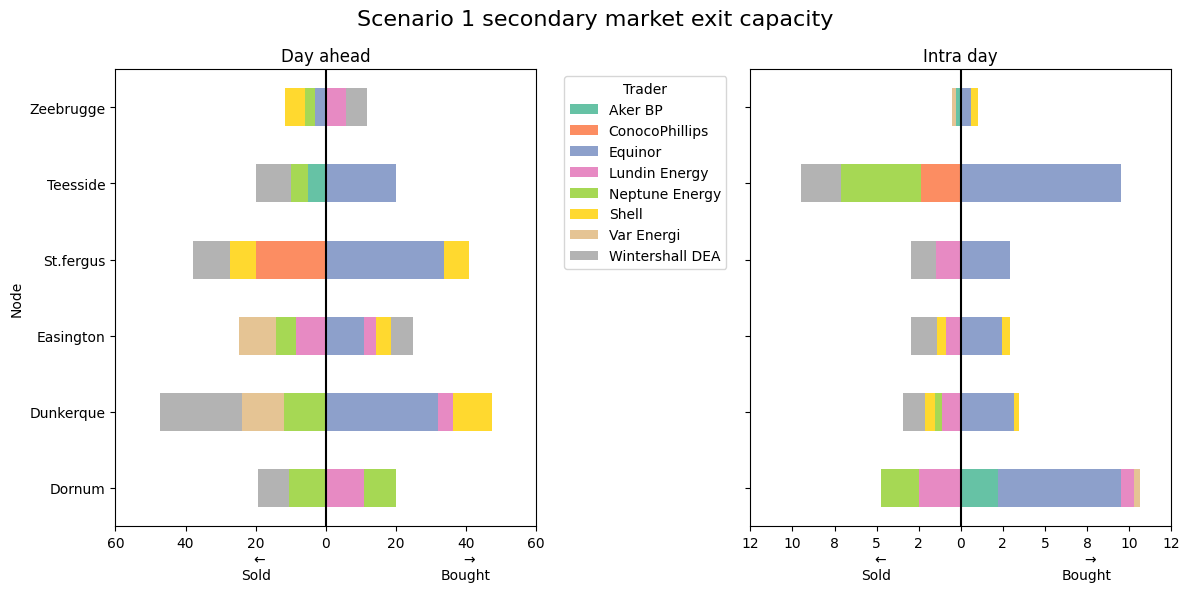

In [231]:
def secondary_market_specific(key, name, stage):
    df = solution[key].copy()

    traders_dict = {t.trader_id: get_short_name(t.name) for t in problem.traders}
    df["Index 3"] = df["Index 3"].map(traders_dict)

    node_dict = {n.node_id: n.name.capitalize() for n in problem.stages[0].nodes}
    df["Index 1"] = df["Index 1"].map(node_dict)

    # Add stages
    df["Stage"] = df["Index 2"].apply(lambda x: 1 if x <= 4 else 2 if x <= 20 else 3)
    df = df[df["Stage"] > 1]
    
    # Add scenarios
    df["Scenario index"] = np.where(
        df["Stage"] == 2,
        (df["Index 2"] - 5) // 4 + 1,
        (df["Index 2"] - 21) // 4 + 1
    )
    
    probabilities = {m.stage_id: m.probability for m in problem.stages}
    df["Probability"] = df["Index 2"].map(probabilities)
    
    df["Weighted value"] = df["Probability"] * df["Value"]
    
    df_stage = df[df["Stage"] == stage]
    df_stage = df_stage.groupby(["Scenario index", "Index 3", "Index 1"]).sum()[["Weighted value"]]

    df_stage.columns = [name]

    return df_stage

def plot_specific(capacity_type, scenario_idx):
    if capacity_type == "exit":
        key = "minus"
    else:
        key = "plus"
        
    # Create figure and subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # Two subplots side by side
    fig.suptitle(f"Scenario {scenario_idx} secondary market {capacity_type} capacity", fontsize=16)
    
    for i, stage in enumerate([2, 3]):
        bought = secondary_market_specific(f"x_{key}", "Bought", stage).loc[scenario_idx,:]
        sold = secondary_market_specific(f"y_{key}", "Sold", stage).loc[scenario_idx,:] * -1
        
        bought_pivot = bought.reset_index().set_index("Index 1").pivot(columns=["Index 3"], values="Bought")
        sold_pivot = sold.reset_index().set_index("Index 1").pivot(columns=["Index 3"], values="Sold")
        
        idx = (~(bought_pivot.eq(0).all(axis=1))) & ~(sold_pivot.eq(0).all(axis=1))
        bought_pivot = bought_pivot.loc[idx]
        sold_pivot = sold_pivot.loc[idx]
        
        bought_pivot.plot(kind="barh", stacked=True, ax=axes[i], cmap="Set2")
        sold_pivot.plot(kind="barh", stacked=True, ax=axes[i], cmap="Set2")

        axes[i].axvline(x=0, color="black")

        axes[i].set_ylabel("Node")

        if stage == 2:
            stage_name = "Day ahead"
        else:
            stage_name = "Intra day"
            
        axes[i].set_title(f"{stage_name}")

        # Get xtick positions and labels
        xticks = axes[i].get_xticks()
        xtick_labels = [f"{abs(tick):.0f}" for tick in xticks]
        
        # Add "Sold" and "Bought" labels
        if any(tick < 0 for tick in xticks):
            negative_indices = [idx for idx, tick in enumerate(xticks) if tick <= 0]
            middle_idx = negative_indices[len(negative_indices) // 2]
            xtick_labels[middle_idx] += "\n " + r"$\leftarrow$" + "\n" + "Sold"
        if any(tick > 0 for tick in xticks):
            positive_indices = [idx for idx, tick in enumerate(xticks) if tick >= 0]
            middle_idx = positive_indices[len(positive_indices) // 2]
            xtick_labels[middle_idx] += "\n " + r"$\rightarrow$" + "\n" + "Bought"
        
        axes[i].set_xticks(xticks)
        axes[i].set_xticklabels(xtick_labels)
        
        # Get legend handles and labels (only for the first subplot)
        handles, labels = axes[i].get_legend_handles_labels()
        
        if i == 0:
            # Remove duplicates
            unique_labels = []
            unique_handles = []
            for h, l in zip(handles, labels):
                if l not in unique_labels:
                    unique_labels.append(l)
                    unique_handles.append(h)
            
            # Add legend only once
            axes[i].legend(unique_handles, unique_labels, title="Trader", bbox_to_anchor=(1.05, 1), loc="upper left")
        else:
            axes[i].legend().set_visible(False)  # Hide legend for second plot

plot_specific("exit", 1)
plt.tight_layout()


Show TSO sales!

In [55]:
result_entry = {}
result_exit = {}
for specific_name in ["long term", "day ahead", "intra day"]:
    for m in problem.stages:
        if m.name == specific_name:
            result_entry[specific_name] = 0
            result_exit[specific_name] = 0
            for m_tilde in m.all_parents + [m]:
                result_entry[specific_name] += sum(m_tilde.probability * get_value_from_solution(f"s_plus[{n.node_id},{m_tilde.stage_id},{k.commodity_id}]", solution) for n in m_tilde.nodes for k in problem.commodities if m_tilde.name == specific_name)
                result_exit[specific_name] += sum(m_tilde.probability * get_value_from_solution(f"s_minus[{n.node_id},{m_tilde.stage_id},{k.commodity_id}]", solution) for n in m_tilde.nodes for k in problem.commodities if m_tilde.name == specific_name)
print("Entry", result_entry)
print("Exit", result_exit)

Entry {'long term': 1152.1886602739726, 'day ahead': 3.1603390410958916, 'intra day': 0.0}
Exit {'long term': 1031.867304109589, 'day ahead': 3.9258643835616445, 'intra day': 7.328703424657534}


# 4.3.2 System throughput

In [ ]:
result = {}
for specific_name in ["day ahead", "intra day"]:
    result[specific_name.capitalize()] = {}
    for n in problem.stages[0].nodes:
        result[specific_name.capitalize()][n.name.capitalize()] = sum(m.probability * get_value_from_solution(f"q_sales[{t.trader_id},{n.node_id},{m.stage_id},{k.commodity_id},{d}]", solution) for m in problem.stages for n_tilde in m_tilde.nodes for t in problem.traders for k in problem.commodities for d in problem.d_list if m.name == specific_name and n_tilde.name == n.name)

In [ ]:
df = pd.DataFrame(result)

# Remove empty rows
df = df.loc[~(df.eq(0).all(axis=1))]

df.T.plot(kind="bar", stacked=True, cmap="Set2")

plt.xticks(rotation=0)

plt.legend(title="Trader", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.ylabel("Sales")

max_flow = 322*4
plt.axhline(y=max_flow, linestyle="--")
plt.text(0.5, max_flow, 'Max flow', fontsize=12, va='center', ha='center', backgroundcolor='w')


plt.show()

# 4.3.3 Use of storage

In [ ]:
result = {"Extraction": {}, "Injection": {}}
for hour in range(1, 5):
    result["Extraction"][hour], result["Injection"][hour] = {}, {}
    for n in problem.stages[0].nodes:
        result["Extraction"][hour][n.name.capitalize()] = sum(m.probability * get_value_from_solution(f"w_minus[{t.trader_id},{n.node_id},{m.stage_id},{k.commodity_id}]", solution) for m in problem.third_stages for t in problem.traders for k in problem.commodities if m.hour == hour)
        result["Injection"][hour][n.name.capitalize()] = sum(m.probability * get_value_from_solution(f"w_plus[{t.trader_id},{n.node_id},{m.stage_id},{k.commodity_id}]", solution) for m in problem.third_stages for t in problem.traders for k in problem.commodities if m.hour == hour)

In [ ]:
# Define hours to compare
hours = [1, 3]

# Create subplots (1 row, 2 columns) and share axes
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)

# Capitalize names
nodes_geo_df["Capitalized names"] = nodes_geo_df.Name.str.capitalize()

# Define a common color range for consistency
vmin, vmax = None, None  # Will be computed dynamically

# First, compute the min/max injection values for normalization
for hour in hours:
    df = pd.DataFrame(result["Injection"])
    df = df.loc[~(df.eq(0).all(axis=1))]  # Remove empty rows
    df_hour = df[hour].to_frame()
    df_hour.columns = ["Injection"]

    temp_gdf = nodes_geo_df.merge(df_hour, left_on='Capitalized names', right_index=True, how='outer')
    temp_gdf["Injection"].fillna(0, inplace=True)  # Fill NaNs with 0
    temp_gdf = temp_gdf[temp_gdf["Injection"] > 0]

    # Update global min/max for color scale normalization
    if vmin is None or temp_gdf["Injection"].min() < vmin:
        vmin = temp_gdf["Injection"].min()
    if vmax is None or temp_gdf["Injection"].max() > vmax:
        vmax = temp_gdf["Injection"].max()

# Now plot with the same color scale
for i, hour in enumerate(hours):
    df = pd.DataFrame(result["Injection"])
    df = df.loc[~(df.eq(0).all(axis=1))]  # Remove empty rows
    df_hour = df[hour].to_frame()
    df_hour.columns = ["Injection"]

    temp_gdf = nodes_geo_df.merge(df_hour, left_on='Capitalized names', right_index=True, how='outer')
    temp_gdf["Injection"].fillna(0, inplace=True)
    temp_gdf = temp_gdf[temp_gdf["Injection"] > 0]

    # Plot
    temp_gdf.plot(
        ax=axes[i], column="Injection", cmap='Blues', vmin=vmin, vmax=vmax, legend=False
    )
    cx.add_basemap(axes[i], crs=32631, source=cx.providers.CartoDB.Positron)

    # Formatting
    axes[i].set_title(f"Hour {hour}", fontsize=18)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Add a common colorbar outside the plots
cbar_ax = fig.add_axes([0.435, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for colorbar
plt.show()


In [ ]:
result = {s: {h: 0 for h in range(1, 5)} for s in range(1, 17)}

market = "Teesside"

n = [node for node in problem.stages[0].nodes if node.name.capitalize() == market][0]

for m in problem.third_stages:
    if m.hour == 4:
        scenario_idx = (m.stage_id - 20) // 4
        for hour in range(1, 5):
            result[scenario_idx][hour] = sum(get_value_from_solution(f"w_plus[{t.trader_id},{n.node_id},{m_tilde.stage_id},{k.commodity_id}]", solution) for m_tilde in m.all_parents + [m] for t in problem.traders for k in problem.commodities if m_tilde.hour == hour)

In [ ]:
pd.DataFrame(result).T.plot(kind="barh", stacked=True, cmap="Set2");

plt.legend(title="Time block", bbox_to_anchor=(1.05, 1), loc="upper left");

plt.ylabel("Scenario index");
plt.xlabel("Injection into storage");

# 4.3.4 Profitability

In [ ]:
def get_objective_per_stage(problem, solution, stage):
    storage_costs_dict = {}
    sales_dict = {}
    production_costs_dict = {}
    flow_costs_dict = {}
    entry_costs_dict = {}
    exit_costs_dict = {}
    objective = 0

    # First part of the objective
    for m in stage.all_parents + [stage]:
        for k in problem.commodities:
            for n in m.nodes:
                for t in problem.traders:
                    supplier_entry_costs = (get_value_from_solution(f"x_plus[{n.node_id},{m.stage_id},{t.trader_id},{k.commodity_id}]", solution) - get_value_from_solution(f"y_plus[{n.node_id},{m.stage_id},{t.trader_id},{k.commodity_id}]", solution)) * n.entry_costs[(t, k)]
                    supplier_exit_costs = (get_value_from_solution(f"x_minus[{n.node_id},{m.stage_id},{t.trader_id},{k.commodity_id}]", solution) - get_value_from_solution(f"y_minus[{n.node_id},{m.stage_id},{t.trader_id},{k.commodity_id}]", solution)) * n.exit_costs[(t, k)]

                    entry_costs_dict[m, n, t, k] = m.probability * supplier_entry_costs
                    exit_costs_dict[m, n, t, k] = m.probability * supplier_exit_costs

                    objective -= (supplier_entry_costs + supplier_exit_costs)

                    if m.name == "intra day":
                        production_costs = get_value_from_solution(f"q_production[{t.trader_id},{n.node_id},{m.stage_id},{k.commodity_id}]", solution) * n.production_costs[(t, k)]
                        storage_costs = get_value_from_solution(f"w_plus[{t.trader_id},{n.node_id},{m.stage_id},{k.commodity_id}]", solution) * n.storage_costs[(t, k)]
                        flow_costs = sum(get_value_from_solution(f"f[{t.trader_id},{a[0]},{a[1]},{m.stage_id},{k.commodity_id}]", solution) * m.get_arc(a).arc_costs[k] for a in problem.incoming_arcs[n.node_id])
                        sales = sum(get_value_from_solution(f"q_sales[{t.trader_id},{n.node_id},{m.stage_id},{k.commodity_id},{d}]", solution) * n.sales_prices[t, d] for d in problem.d_dict[k])

                        storage_costs_dict[m, n, t, k] = problem.stages[m.stage_id - 1].probability * storage_costs
                        sales_dict[m, n, t, k] = problem.stages[m.stage_id - 1].probability * sales
                        production_costs_dict[m, n, t, k] = problem.stages[m.stage_id - 1].probability * production_costs
                        flow_costs_dict[m, n, t, k] = problem.stages[m.stage_id - 1].probability * flow_costs

                        objective += (sales - production_costs - storage_costs - flow_costs)

    return objective, sales_dict, production_costs_dict, storage_costs_dict, flow_costs_dict, entry_costs_dict, exit_costs_dict

In [ ]:
result = {}

for m in problem.third_stages:
    if m.hour == 4:
        scenario_idx = (m.stage_id - 20) // 4
        
        objective, sales_dict, production_costs_dict, storage_costs_dict, flow_costs_dict, entry_costs_dict, exit_costs_dict = get_objective_per_stage(problem, solution, m)

        result[scenario_idx] = {"Profit": objective,
                               "Production costs": sum(production_costs_dict.values()),
                               "Storage costs": sum(storage_costs_dict.values()),
                               "Transportation costs": sum(flow_costs_dict.values()),
                               "Entry costs": sum(entry_costs_dict.values()),
                               "Exit costs": sum(exit_costs_dict.values())}

In [ ]:
pd.DataFrame(result).T.plot(kind="bar", stacked=True, cmap="Set2");

plt.legend(title="Profit and costs", bbox_to_anchor=(1.05, 1), loc="upper left");

plt.ylabel("Euro");
plt.xlabel("Scenario index");
plt.xticks(rotation=0);
plt.title("Profitability per scenario");

# 4.3.5 Sensitivity for utilisation rates

In [90]:
df["Index 2"]

32        5
33        5
34        5
35        5
36        5
         ..
39643    84
39644    84
39645    84
39646    84
39647    84
Name: Index 2, Length: 37760, dtype: int64

In [ ]:
result = {}

for beta in [0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 1]:
    input_file = f"Results/result_F{beta}"
    
    problem, solution = read_data(input_file)

    result[beta] = 0

    for m in problem.third_stages:
        if m.hour == 4:
            objective, *_ = get_objective_per_stage(problem, solution, m)

            result[beta] += m.probability * objective

In [ ]:
plt.plot(result.keys(), result.values(), "o-");

plt.xlabel(r"$\beta$");
plt.ylabel("Profit (€)");

plt.title("Sensitivity to utilisation rates");